In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import re
import pandas as pd
from PIL import Image
import numpy as np
import shutil
import gc


def load_images_from_folder(folder, dataset):
    data = []
    genre_counts = {}
    dataset_resize_value = {
        'gtzan' : (61, 37),
        'homburg' : (55, 34),
        # 'ismir2004' : (125, 75)
        'ismir2004' : (61, 37)
    }

    for genre in os.listdir(folder):
        genre_path = os.path.join(folder, genre)
        if os.path.isdir(genre_path):
            genre_counts[genre] = 0
            for filename in os.listdir(genre_path):
                img_path = os.path.join(genre_path, filename)
                if os.path.isfile(img_path) and filename.lower().endswith(('png', 'jpg', 'jpeg')):
                    # Load image
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize(dataset_resize_value[dataset])
                    img_array = np.array(img).flatten()     # Flatten the image into a 1D array

                    # Update genre counts
                    genre_counts[genre] += 1
                    label_1 = f"{genre}_{genre_counts[genre]}"

                    # Create a row for the DataFrame
                    row = [genre, label_1] + img_array.tolist()
                    data.append(row)

                    del img
                    del img_array
                    del row
                    del label_1
                    gc.collect()

                    print('Processed file ' + img_path)

    # Create column names for the DataFrame
    num_pixels = len(data[0]) - 2  # Subtracting the two label columns
    columns = ['label', 'label_1'] + [f'pixel_{i}' for i in range(num_pixels)]

    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df

# Utility function to move subfolders to parent folder
def move_subfolders_to_parent(folder_path):
  # Iterate through subdirectories of folder2
  for root, dirs, files in os.walk(folder_path):
    for subdir in dirs:
      subdir_path = os.path.join(root, subdir)
      # Move each subdirectory to folder1
      shutil.move(subdir_path, os.path.dirname(folder_path))


def remove_images_with_suffix_greater_than_3(folder_path):
    # Define the pattern to match filenames ending with -X.extension where X > 3
    pattern = re.compile(r'-(\d+)\.(jpg|jpeg|png|bmp|gif|tiff)$', re.IGNORECASE)

    for root, _, files in os.walk(folder_path):
        for file_name in files:
            # Check if the file name matches the pattern
            match = pattern.search(file_name)
            if match:
                number = int(match.group(1))
                # Check if the number is greater than 3
                if number >= 3:
                    file_path = os.path.join(root, file_name)
                    try:
                        os.remove(file_path)
                        print(f"Removed: {file_path}")
                    except Exception as e:
                        print(f"Error removing {file_path}: {e}")

# Utility function to delete directories
def delete_directory(directory):
  """Deletes a directory and all its contents.

  Args:
      directory (str): The path to the directory to be deleted.
  """
  print('Deleting directory ' + directory)
  try:
    shutil.rmtree(directory)
    print(f"Directory '{directory}' and all its contents have been successfully deleted.")
  except Exception as e:
    print(f"An error occurred while deleting the directory '{directory}': {e}")

In [10]:
# datasets = [
#     'gtzan_aim',
#     'homburg_aim',
#     'ismir2004_aim']

datasets = [
    # 'gtzan_spectrum',
    # 'homburg_spectrum',
    'ismir2004_spectrum'
    ]
datasets_drive_path = '/content/drive/MyDrive/Università/NAML_project/datasets_processed/'

for dataset in datasets:
  # upload and unzip the dataset from google drive
  dataset_folder = datasets_drive_path + dataset + '.zip'
  # !unzip "$dataset_folder"

  # move_subfolders_to_parent('/content/content')

  folder_path = '/content/' + dataset

  remove_images_with_suffix_greater_than_3(folder_path)

  df = load_images_from_folder(folder_path, dataset.split('_')[0])

  print(df.head())
  print(len(df))

Processed file /content/ismir2004_spectrum/classical/14-fantasia_xviii_(de_rippe)-2.jpg
Processed file /content/ismir2004_spectrum/classical/8-tamerlano_act_i_track_8-1.jpg
Processed file /content/ismir2004_spectrum/classical/25-galliard_muy_linda_(lute)-2.jpg
Processed file /content/ismir2004_spectrum/classical/7-toccata_xvii-2.jpg
Processed file /content/ismir2004_spectrum/classical/21-fantasia_42_(severino)-1.jpg
Processed file /content/ismir2004_spectrum/classical/6-set_a_6_in_g_minor-2.jpg
Processed file /content/ismir2004_spectrum/classical/18-handel_oxford_water_music_suit-2.jpg
Processed file /content/ismir2004_spectrum/classical/14-tamerlano_act_ii_track_14-1.jpg
Processed file /content/ismir2004_spectrum/classical/14-fantasia_26-2.jpg
Processed file /content/ismir2004_spectrum/classical/13-fantasia_decima-2.jpg
Processed file /content/ismir2004_spectrum/classical/4-tamerlano_act_ii_track_4-2.jpg
Processed file /content/ismir2004_spectrum/classical/8-caprice_de_chaconne-2.jpg


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

def initialize_params(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    W = np.random.randn(layers_size[i+1], layers_size[i]) * np.sqrt(2 / (layers_size[i+1] + layers_size[i]))
    b = np.zeros((layers_size[i+1], 1))
    params.append(W)
    params.append(b)
  return params

activation = jnp.tanh

def ANN(x, params):
  layer = x
  num_layers = int(len(params) / 2 + 1)
  weights = params[0::2]
  biases = params[1::2]
  for i in range(num_layers - 1):
    layer = weights[i] @ layer - biases[i]
    if i < num_layers - 2:
      layer = activation(layer)
  layer_exp = jnp.exp(layer)
  layer = layer_exp / np.sum(layer_exp, axis = 0)
  return layer

In [12]:
def MSE(x, y, params):
  y_pred = ANN(x, params)
  return jnp.mean(jnp.square(y - y_pred))

def cross_entropy(x, y, params):
  y_pred = ANN(x, params)
  return - jnp.mean(jnp.sum(y * jnp.log(y_pred), axis = 0))

def accuracy(x, y, params):
  y_pred = ANN(x, params)
  labels = jnp.argmax(y, axis = 0)
  labels_pred = jnp.argmax(y_pred, axis = 0)
  return jnp.mean(labels == labels_pred)

# print('MSE:       %f' % MSE(x_data, y_data, params))
# print('X entropy: %f' % cross_entropy(x_data, y_data, params))
# print('accuracy:  %f' % accuracy(x_data, y_data, params))

In [13]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1, figsize=(16,8))
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs.clear()
      epochs = np.arange(1,len(history_train_Xen) + 1)
      self.axs.loglog(epochs, history_train_Xen, label = 'train_Xen')
      self.axs.loglog(epochs, history_valid_Xen, label = 'valid_Xen')
      self.axs.loglog(epochs, history_valid_MSE, label = 'valid_MSE')
      self.axs.loglog(epochs, history_valid_acc, label = 'valid_acc')

      self.axs.legend()
      self.axs.set_title('epoch %d - accuracy %0.1f%%' % (self.epoch + 1, 100*history_valid_acc[-1]))

In [14]:
from sklearn.preprocessing import LabelEncoder

shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

label_encoder = LabelEncoder()

shuffled_df['label'] = label_encoder.fit_transform(shuffled_df['label'])

labels = shuffled_df['label'].to_numpy()

print(len(labels))

2078


In [15]:
# gtzan
# labels_num = 10
# homburg
# labels_num = 9
# ismir2004
labels_num = 8

y_data = np.zeros((labels_num, len(labels)))
for i in range(labels_num):
  y_data[i, labels==i] = 1

x_data = shuffled_df.drop(columns=['label', 'label_1']).to_numpy()

x_data = x_data.transpose() / 255

print(len(y_data))
print(len(x_data))

8
2257


(1.0, 1.0, 0)

In [16]:
# Gtzan
# x_data_train = x_data[:,598:]
# y_data_train = y_data[:,598:]
# x_data_valid = x_data[:,:598]
# y_data_valid = y_data[:,:598]

# Homburg
# x_data_train = x_data[:,374:]
# y_data_train = y_data[:,374:]
# x_data_valid = x_data[:,:374]
# y_data_valid = y_data[:,:374]

# ismri2004
x_data_train = x_data[:,418:]
y_data_train = y_data[:,418:]
x_data_valid = x_data[:,:418]
y_data_valid = y_data[:,:418]

In [17]:
x_data.shape, y_data.shape

((2257, 2078), (8, 2078))

In [18]:
x_data_train.shape, y_data_train.shape, x_data_valid.shape, y_data_valid.shape,

((2257, 1660), (8, 1660), (2257, 418), (8, 418))

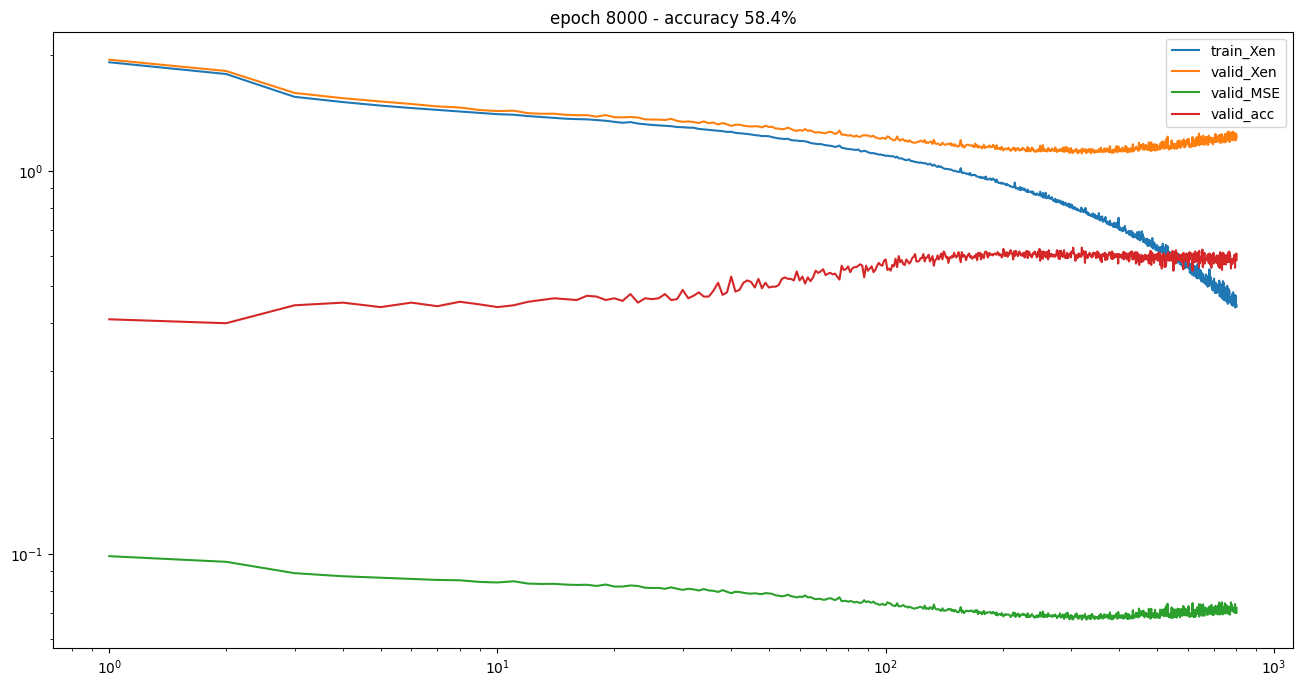

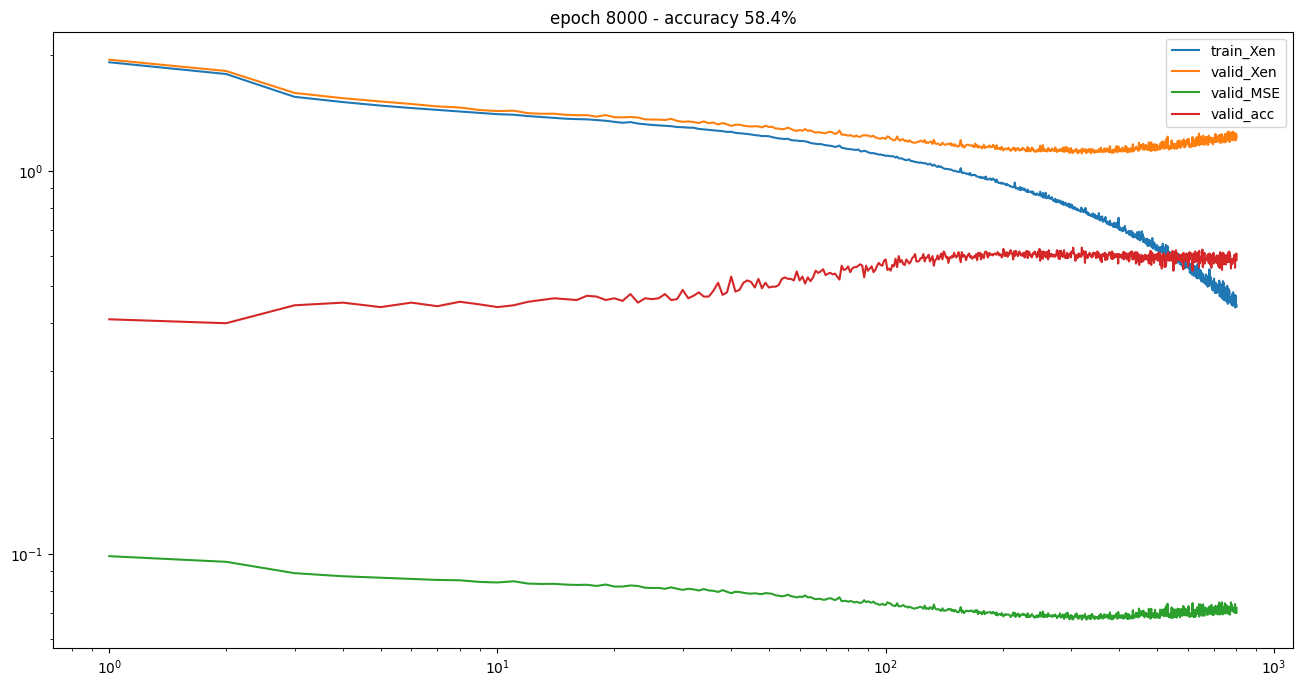

In [20]:
# Hyperparameters
# gtzan
# layers_size = [2257, 1128, 564, 282, 70, 10]
# homburg
# layers_size = [1870, 935, 468, 234, 58, 9]
# ismir2004
layers_size = [2257, 1128, 564, 282, 70, 8]
# Training options
num_epochs = 8000
#gtazn
# batch_size = 598
#homburg
# batch_size = 374
# ismi2004
batch_size = 418
learning_rate = 7e-6
decay_rate = .9
delta = 1e-7

params = initialize_params(layers_size)

grad = jax.grad(cross_entropy, argnums = 2)
grad_jit = jax.jit(grad)

cross_entropy_jit = jax.jit(cross_entropy)
MSE_jit = jax.jit(MSE)
accuracy_jit = jax.jit(accuracy)

history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()
def dump():
  history_train_Xen.append(cross_entropy_jit(x_data_train, y_data_train, params))
  history_valid_Xen.append(cross_entropy_jit(x_data_valid, y_data_valid, params))
  history_valid_MSE.append(MSE_jit(x_data_valid, y_data_valid, params))
  history_valid_acc.append(accuracy_jit(x_data_valid, y_data_valid, params))

dump()
cb = Callback(refresh_rate = 50)

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  idxs = np.random.choice(len(x_data_train[0]), batch_size)
  grads = grad_jit(x_data_train[:,idxs], y_data_train[:,idxs], params)

  for i in range(len(params)):
    cumulated_square_grad[i] = decay_rate*cumulated_square_grad[i] + (1 - decay_rate) * grads[i] * grads[i]
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]

  if epoch % 10 == 0:
    dump()
  cb(epoch)
cb.draw()

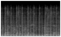

In [8]:
import PIL

path = '/content/gtzan_spectrum/blues/blues.00000-0.jpg'

img = Image.open(path).convert('L')  # Convert to grayscale
img = img.resize((61, 37))

display(img)

In [ ]:
import os
count = 0
for path in os.listdir('/content/ismir2004_spectrum'):
  for file in os.listdir('/content/ismir2004_spectrum/' + path):
    count += 1

print(count)

17307
